In [1]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

import torch
import torch.nn as nn
import torch.functional as F

from netam import framework, models
from netam.common import pick_device, parameter_count_of_model

In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

site_count=500
batch_size=1024
device = pick_device()
# device = "cpu" # pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) # , sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset.nickname = nickname
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    nickname = val_dataset.nickname
    save_dir = f"_ignore/model_comparison_pretrained/{nickname}"
    crepe_path = f"{save_dir}/{model_name}"
    train_dataset.to(device)
    val_dataset.to(device)
    if framework.crepe_exists(crepe_path):
        crepe = framework.load_crepe(crepe_path)
        print(f"\tLoaded {model_name}...")
        model_instance = crepe.model
        model_instance.to(device) 
        burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
        epochs_used = 0
    else:
        model_instance.to(device)
        burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
        train_history = burrito.multi_train(epochs=epochs, max_tries=3)
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        burrito.save_crepe(crepe_path)
        epochs_used = len(train_history)
        

    val_loss = burrito.evaluate()
    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': val_loss, 'epochs_used': epochs_used}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    # train_dataset_1, val_dataset_1 = data_of_nickname(nickname, kmer_length=1)
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_1 = {
        # _ignore/optuna_CNN1merModel_20231125_071248.csv
        # Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.2, 'num_filters': 17}
        # "cnn_1mer": models.CNN1merModel(train_dataset_1, num_filters=17, kernel_size=11, dropout_rate=0.2)
    }
    
    model_instances_3 = {
        "cnn_med": models.CNNModel(kmer_length=3, embedding_dim=9, filter_count=9, kernel_size=11, dropout_rate=0.1),
        "cnn_med_drp02": models.CNNModel(kmer_length=3, embedding_dim=9, filter_count=9, kernel_size=11, dropout_rate=0.2),
        "cnn_med_k11": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=13, kernel_size=11, dropout_rate=0.3),
        "cnn_med_k11_drp02": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=13, kernel_size=11, dropout_rate=0.2),
        "cnn_med_new": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=16, kernel_size=9, dropout_rate=0.1),
        "cnn_med_new_drp02": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=16, kernel_size=9, dropout_rate=0.2),
        "cnn_med_new_drp03": models.CNNModel(kmer_length=3, embedding_dim=7, filter_count=16, kernel_size=9, dropout_rate=0.3),
        # "cnn_med_k9d6": models.CNNModel(kmer_length=3, embedding_dim=6, filter_count=20, kernel_size=9, dropout_rate=0.2),
        # "cnn_med_k9d6_drp03": models.CNNModel(kmer_length=3, embedding_dim=6, filter_count=20, kernel_size=9, dropout_rate=0.3),
    }

    model_instances_5 = {
        "fivemer": models.FivemerModel(kmer_length=5),
        "shmoof": models.SHMoofModel(kmer_length=5, site_count=site_count),
    }
     
    comparison_df = \
        pd.concat([# comparison_of_data(model_instances_1, train_dataset_1, val_dataset_1),
                   comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                   comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
                ])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Loaded cnn_med...
	Loaded cnn_med_drp02...
	Loaded cnn_med_k11...
	Loaded cnn_med_k11_drp02...
	Loaded cnn_med_new...
	Loaded cnn_med_new_drp02...
	Loaded cnn_med_new_drp03...
	Loaded fivemer...
	Loaded shmoof...
Val nickname is 88
	Loaded cnn_med...
	Loaded cnn_med_drp02...
	Loaded cnn_med_k11...
	Loaded cnn_med_k11_drp02...
	Loaded cnn_med_new...
	Loaded cnn_med_new_drp02...
	Loaded cnn_med_new_drp03...
	Loaded fivemer...
	Loaded shmoof...
Val nickname is 97
	Loaded cnn_med...
	Loaded cnn_med_drp02...
	Loaded cnn_med_k11...
	Loaded cnn_med_k11_drp02...
	Loaded cnn_med_new...
	Loaded cnn_med_new_drp02...
	Loaded cnn_med_new_drp03...
	Loaded fivemer...
	Loaded shmoof...
Val nickname is small
	Loaded cnn_med...
	Loaded cnn_med_drp02...
	Loaded cnn_med_k11...
	Loaded cnn_med_k11_drp02...
	Loaded cnn_med_new...
	Loaded cnn_med_new_drp02...
	Loaded cnn_med_new_drp03...
	Loaded fivemer...
	Loaded shmoof...


,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.057967,0
1,59,cnn_med_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.057973,0
2,59,cnn_med_k11,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1483,0.058034,0
3,59,cnn_med_k11_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1483,0.057990,0
4,59,cnn_med_new,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.057917,0
5,59,cnn_med_new_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.057959,0
6,59,cnn_med_new_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.058084,0
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058232,0
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.058109,0
0,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050371,0


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_50867/2153285373.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")


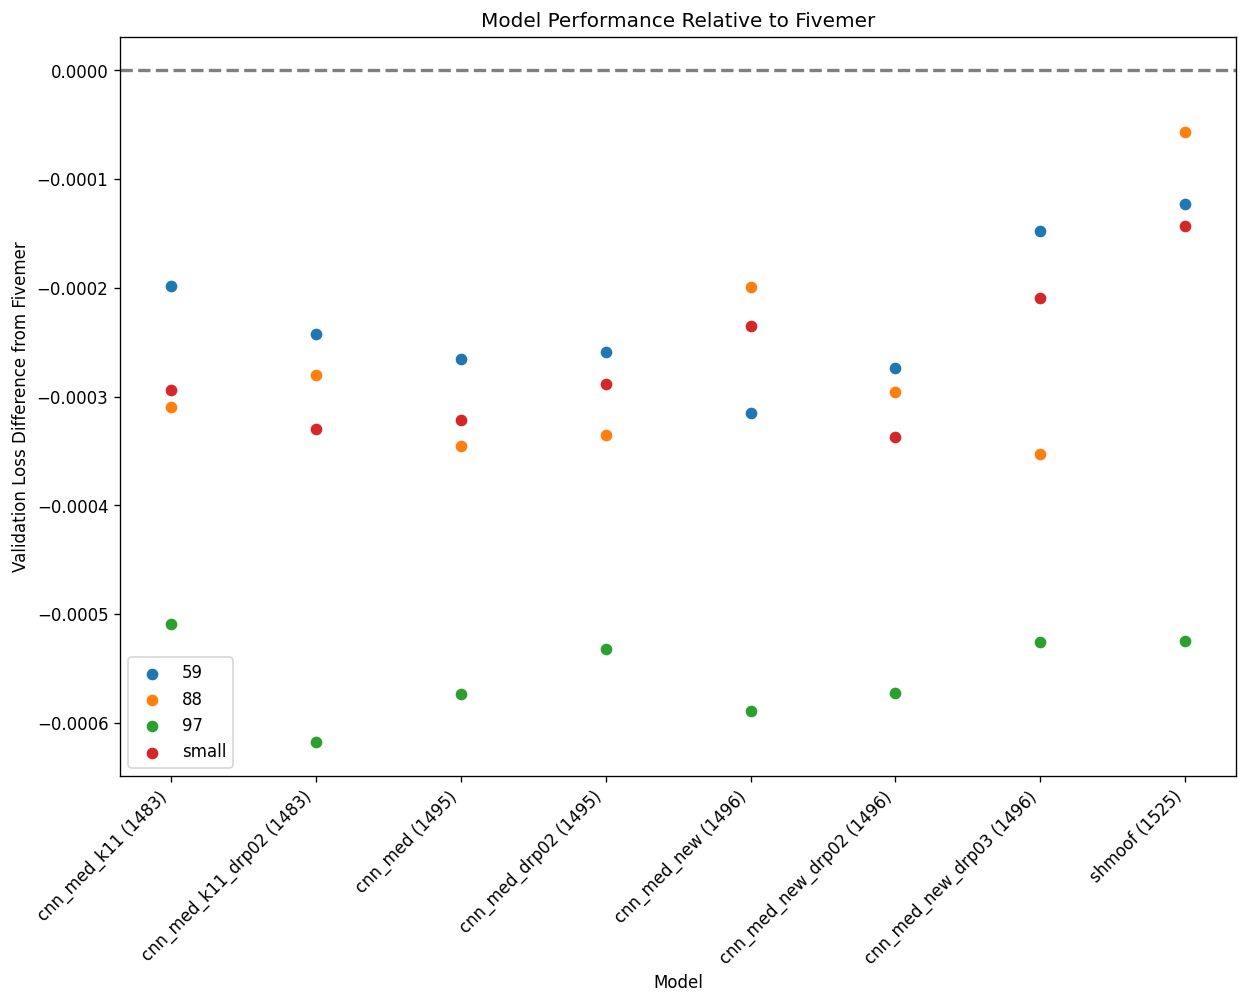

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df 

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
model_to_xlabel_str = {}
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model_name'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            model_label = f"{row['model_name']} ({row['parameter_count']})"
            model_to_xlabel_str[row['model_name']] = model_label
            loss_diffs.append({'val_nickname': nickname, 'model_name': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame and sort by parameter count
loss_diff_df = pd.DataFrame(loss_diffs)
# sort first by parameter count then by model name
loss_diff_df = loss_diff_df.sort_values(by=['parameter_count', 'model_name'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['model_name'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Model')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")
ax.legend()
plt.show()


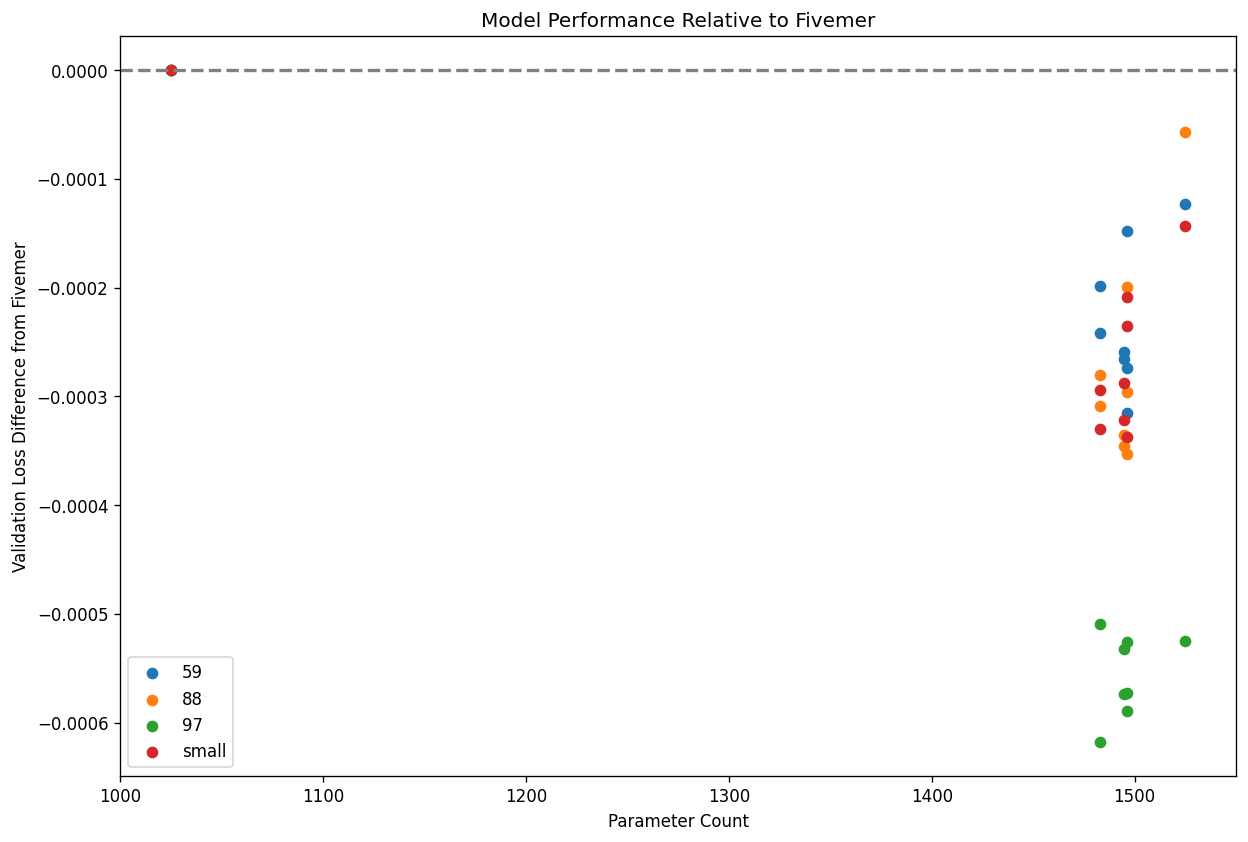

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


In [7]:
final_df

,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.057967,0
1,59,cnn_med_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.057973,0
2,59,cnn_med_k11,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1483,0.058034,0
3,59,cnn_med_k11_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1483,0.057990,0
4,59,cnn_med_new,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.057917,0
5,59,cnn_med_new_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.057959,0
6,59,cnn_med_new_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1496,0.058084,0
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058232,0
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.058109,0
0,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050371,0
